In [1]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
from scipy.stats import pearsonr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 100)

### 1. Read SCM & ERA data

In [2]:
# Read ERA data
era_final = pd.read_csv("files/ERA/processed/era_final_features.csv")
era_raw = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments.csv").assign(model="ERA", init_month=12)
#era_raw_unstructured = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments_not_structured.csv").assign(model="ERA", init_month=12)

# Read SCM data 
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
scm = pd.concat([c3s, nmme], ignore_index=True).drop_duplicates().rename(columns={"forecasted_month":"month"})
scm["rain"] = scm["rain"].apply(lambda x: x*1000)

# Read study region polygon
study_region = gpd.read_file("files/shapefiles/study_region.shp")

# Filter SCM data by month and model
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(6, 11) & (scm["model"].isin(['GFDL', 'CCSM4', 'NASA', 'CMCC', 'DWD', 'ECMWF', 'METFR', 'UKMO', 'ECCC', 'NCEP'])))].reset_index(drop=True)

# Filter SCM data by grid cells of study region
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"], crs="EPSG:4326"))
coordinates = gpd.sjoin(scm[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
scm = scm.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

scm.head(2)

,model,year,init_month,month,rain,tmean,lat,lon,geometry
0,CMCC,1993,6,9,1.186496,11.175531,-40.0,-63.0,POINT (-63.00000 -40.00000)
1,CMCC,1993,6,10,1.468906,14.735773,-40.0,-63.0,POINT (-63.00000 -40.00000)


Store variable names:

In [3]:
# Unique SCM
climate_models = scm["model"].unique().tolist()
climate_models.sort()

# Grid cells for final model
features_grid_cells = list(set(["_".join(c.split("_")[1:3]) for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))

# Meteorological indices used by end-of-season model
features = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

# Coordinates as 2d list
coordinates = [c.split("_") for c in features_grid_cells]

# Extract features needed for basis expansion, e.g. Tmean_Oct if Tmean_squared_Oct is used for final model
features_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys(["_".join(c.split("_")[1:3]) for c in features if ("tmean" in c)]), dict.fromkeys(["_".join(c.split("_")[1:3]) for c in features if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in features if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            features_raw.append("{}_{}_{}".format(var, loc, month))

### 2. Filter SCM & ERA raw dataset by relevant grid cells

In [4]:
# Filter ERA
era_raw = era_raw.loc[:, ["year", "model", "init_month"] + features_raw]

def filter_grid_cells(df):
    # Filter SCM (keep two neighboring grid cells as well)
    li = []
    df["loc"] = np.nan
    for c in coordinates:
        lat = int(c[0])
        lon = int(c[1])
        
        data = df.loc[((df["lat"] == lat) & (df["lon"] == lon)) | ((df["lat"] == lat-1) & (df["lon"] == lon-1)) 
                    | ((df["lat"] == lat+1) & (df["lon"] == lon+1))].copy()
        
        data.loc[((df["lat"] == lat) & (df["lon"] == lon)), "loc"] = "loc_orig"
        data.loc[((df["lat"] == lat-1) & (df["lon"] == lon-1)), "loc"] = "loc_n1"
        data.loc[((df["lat"] == lat+1) & (df["lon"] == lon+1)), "loc"] = "loc_n2"
        
        data.loc[:, "lat"] = lat
        data.loc[:, "lon"] = lon
        
        li.append(data)

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [5]:
scm = filter_grid_cells(scm)

### 3. Bring SCM hindcasts into feature structure

In [6]:
scm_pivot = scm.pivot_table(
                            index=["model", "year", "init_month", "loc"],
                            columns=["lat", "lon", "month"],
                            values=["tmean", "rain"]
                    )
scm_pivot.columns = ["{}_{}_{}_{}".format(c[0], int(c[1]), int(c[2]), c[3]) for c in scm_pivot.columns]
scm_pivot = scm_pivot[features_raw].reset_index()

scm_pivot.head()

,model,year,init_month,loc,tmean_-38_-62_11,tmean_-31_-61_10,rain_-38_-62_11,rain_-31_-61_10,rain_-31_-61_11,rain_-36_-62_9
0,CCSM4,1993,6,loc_n1,19.865289,22.007547,1.442453,2.381513,3.319848,1.224823
1,CCSM4,1993,6,loc_n2,20.579034,22.644968,2.691816,3.317811,3.893459,1.371600
2,CCSM4,1993,6,loc_orig,20.450403,22.388498,2.258088,2.798091,3.445857,1.301647
3,CCSM4,1993,7,loc_n1,19.641229,21.318323,1.431106,2.707965,3.141649,1.437231
4,CCSM4,1993,7,loc_n2,19.969827,22.017175,2.851885,3.527866,4.021517,1.703101


### 4. Adjust Bias

In [7]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in predicted["init_month"].unique().tolist():
            adjusted_cols = []
            for col in features_raw:
                adjusted_years = []
                for year in list(range(1993, 2017)):
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month", "loc"]].copy()

                    # Perform bias-adjustment 
                    if (int(col.split("_")[-1]) >= month):
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        if ("tmean" in col):
                            hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                            hindcast_to_be_adjusted.name = col
                        elif ("rain" in col):
                            hindcast_to_be_adjusted = hindcast_to_be_adjusted * observations_used_as_reference.mean() / hindcast_used_as_reference.mean()
                        #    hindcast_to_be_adjusted = bc_col.correct(method="normal_mapping")
                            hindcast_to_be_adjusted.name = col

                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [8]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "normal_mapping")
scm_bias_adjusted = scm_bias_adjusted.groupby(["model", "year", "init_month"])[features_raw].mean().reset_index()

scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_-38_-62_11,tmean_-31_-61_10,rain_-38_-62_11,rain_-31_-61_10,rain_-31_-61_11,rain_-36_-62_9
953,METFR,2007,11,17.169770,NaN,2.447645,NaN,4.349727,NaN
104,CCSM4,2010,8,17.994948,20.209240,2.423251,4.136086,4.151858,1.865521
717,ECMWF,2016,9,17.399665,19.840271,2.759770,5.694637,4.384242,1.718559


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO scheme, separately for each model.

In [9]:
def standardize_loyo(scm_df, era_df):
    scm_df = scm_df.copy()
    era_df = era_df.copy()
    standardized_data = []
    for model in scm_df["model"].unique():
        standardized_data_init_month = []
        for month in scm_df["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = era_df.loc[(era_df["year"] != year), [c for c in era_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), [c for c in scm_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_df.loc[:, [c for c in [l for l in standardized_df.columns if ("tmean" in l) or ("rain" in l)] if (int(c.split("_")[-1]) < month)]] = np.nan
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(scm_df, era_raw_df, era_final_df, final_features):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(scm_df, era_raw_df)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])

    for col in final_features:
        type_of_expansion = col.split("_")[0]
        location = "_".join(col.split("_")[1:3])
        month = col.split("_")[3]
        
        if type_of_expansion == "tmeansquared":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            df_standardized[col] = tmean.mul(tmean)
        if type_of_expansion == "rainsquared":
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain.mul(rain)
        if type_of_expansion == "tmeanrain":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain * tmean.values
    
    df_standardized = df_standardized[final_features].reset_index()
    
    # standardize expanded features again
    df_standardized = standardize_loyo(df_standardized, era_final_df)
    df_standardized = df_standardized.groupby(["model", "year", "init_month"]).mean()[final_features].reset_index()
    
    return df_standardized

In [10]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted, era_raw, era_final, features)
scm_basis_expansion.sample(3)

,model,year,init_month,tmeansquared_-38_-62_11,tmeanrain_-38_-62_11,rainsquared_-31_-61_11,rainsquared_-36_-62_9,tmeanrain_-31_-61_10
979,METFR,2012,7,-0.123233,-0.003396,-0.040368,-0.064074,0.077016
722,GFDL,1993,8,0.015835,-0.153137,0.041024,-0.037638,-0.297149
1410,UKMO,2012,6,-0.070499,0.087878,0.270163,-0.068597,0.131059


In [11]:
scm_basis_expansion.model.unique()

array(['CCSM4', 'CMCC', 'DWD', 'ECCC', 'ECMWF', 'GFDL', 'METFR', 'NASA',
       'NCEP', 'UKMO'], dtype=object)

### 5. Fill past months with ERA data

In [12]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield anomaly [%],tmeansquared_-38_-62_11,tmeanrain_-38_-62_11,rainsquared_-31_-61_11,rainsquared_-36_-62_9,tmeanrain_-31_-61_10
301,1995,DWD,7,-0.100671,-0.114829,0.059840,-0.044251,-0.027496,0.093848
1187,1994,NCEP,11,0.020172,-0.064785,-0.068408,0.002336,-0.326815,-0.745231
736,2009,ERA,12,0.083647,-0.531278,0.042539,0.572127,1.571934,-0.609164
595,1996,ECMWF,7,0.043842,-0.060075,-0.065377,-0.043738,-0.028822,0.067249
545,2011,ECCC,11,0.195224,-0.044438,0.413426,0.095640,0.635433,0.310548


### 6. Calculate performance metrics

We will use the coefficients learned from the ERA wheat yield model to identify the best SCM. The error can be interpreted as the average wheat yield variability error added from the model.

In [13]:
# Calculate error (bias) for each feature
scm_error = scm_era.loc[scm_era["model"] != "ERA"].sort_values(by=["model", "init_month", "year"]).reset_index(drop=True).copy()
era_mae = pd.concat(len(scm_error["model"].unique()) * len(scm_error["init_month"].unique()) * [era_final.copy()], axis=0, ignore_index=True)
scm_error[features] = scm_error[features] - era_mae[features]
scm_error = scm_error.set_index(["model", "init_month"])[features]

# MEAN ABSOLUTE ERROR
scm_mae = scm_error.copy()
# 1. Set 0s to Nan so that they are ignored for mean
scm_mae = scm_mae.replace({0:np.nan})
# 2. Absolute mean
scm_mae = scm_mae.abs().mean(axis=1, skipna=True).reset_index(name="MAE")
# 3. Average across all years
scm_mae = scm_mae.groupby(["model", "init_month"]).mean().reset_index()

# WEIGHTED MEAN ABSOLUTE ERROR
scm_wmae = scm_error.copy()
# 1. Read weights (coefficients) from end-of-season yield model
weights = pd.read_csv("files/ERA/ERA_features_and_coefficients.csv")
weights = weights.loc[weights["index"].isin(features)].reset_index(drop=True)
# 2. Calculate sum of weights based on init_month
sum_of_weights_init_month_6_9 = weights["coefficient"].abs().sum()
sum_of_weights_init_month_10 = sum_of_weights_init_month_6_9 - weights.loc[weights["index"] == "rainsquared_-36_-62_9", "coefficient"].abs().values[0]
sum_of_weights_init_month_11 = sum_of_weights_init_month_10 - weights.loc[weights["index"] == "tmeanrain_-31_-61_10", "coefficient"].abs().values[0]
# 3. Multiply each feature error with its coefficient
scm_wmae = scm_wmae[weights["index"].tolist()]
scm_wmae = scm_wmae.mul(weights["coefficient"].tolist())
# 4. Absolute sum
scm_wmae = scm_wmae.abs().sum(axis=1).reset_index(name="WMAE")
# 5. Divide by sum of weights
scm_wmae.loc[scm_wmae["init_month"].between(6, 9), "WMAE"] /= sum_of_weights_init_month_6_9
scm_wmae.loc[scm_wmae["init_month"] == 10, "WMAE"] /= sum_of_weights_init_month_10
scm_wmae.loc[scm_wmae["init_month"] == 11, "WMAE"] /= sum_of_weights_init_month_11
# 6. Average across all years
scm_wmae = scm_wmae.groupby(["model", "init_month"]).mean().reset_index()

# ABSOLUTE WEIGHTED SUM OF ERRORS
scm_awse = scm_error.copy()
# 1. Multiply each feature error with its coefficient
scm_awse = scm_awse.mul(weights.coefficient.tolist())
# 2. Sum and absolute
scm_awse = scm_awse.sum(axis=1).abs().reset_index(name="AWSE")
# 3. Average across all years
scm_awse_year = scm_awse.groupby(["model", "init_month"]).mean().reset_index()

In [14]:
data_plot_mae = scm_mae.pivot(index="model", columns="init_month", values="MAE")
data_plot_wmae = scm_wmae.pivot(index="model", columns="init_month", values="WMAE")
data_plot_awse = scm_awse_year.pivot(index="model", columns="init_month", values="AWSE")

In [15]:
data_plot_mae["Mean"] = data_plot_mae.mean(axis=1)

In [16]:
data_plot_mae.sort_values(by="Mean")

init_month,6,7,8,9,10,11,Mean
model,,,,,,,
ECMWF,0.775454,0.769092,0.779383,0.792436,0.728500,0.699975,0.757473
METFR,0.775905,0.780625,0.780788,0.783874,0.772955,0.728805,0.770492
NCEP,0.764384,0.764902,0.778072,0.790234,0.803969,0.728803,0.771727
GFDL,0.740154,0.764920,0.772104,0.847552,0.766203,0.755148,0.774347
CMCC,0.767896,0.771132,0.787870,0.811747,0.769396,0.745579,0.775603
CCSM4,0.785329,0.789089,0.799806,0.787082,0.774702,0.757314,0.782220
ECCC,0.789723,0.785361,0.804869,0.828909,0.788439,0.699089,0.782732
UKMO,0.767977,0.799467,0.791929,0.827584,0.819469,0.818807,0.804205
DWD,0.798699,0.780612,0.785951,0.819052,0.804177,0.837129,0.804270


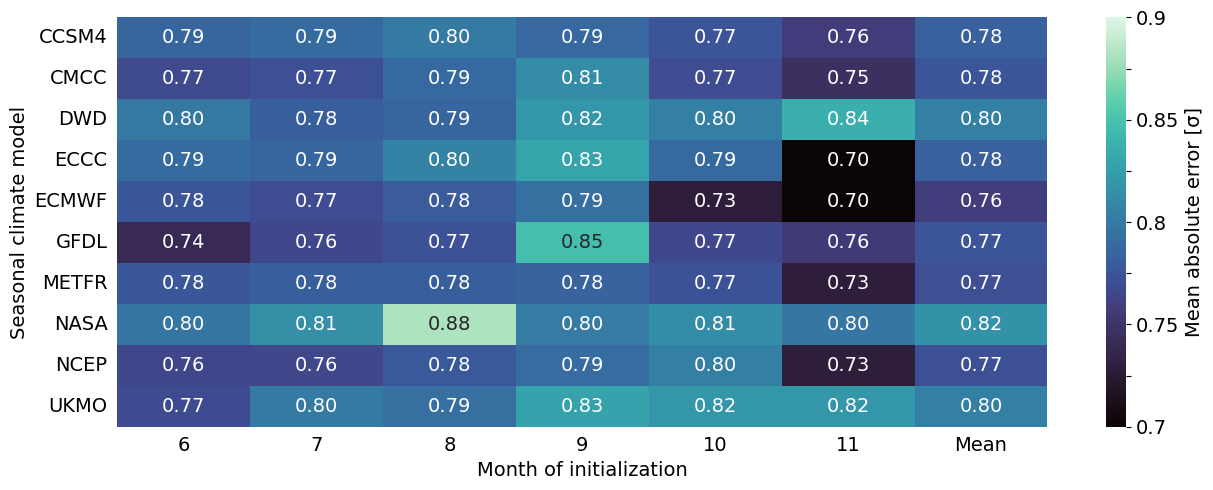

In [17]:
fontsize=14
fig, axs = plt.subplots(1, 1, figsize=(13,5))


sns.heatmap(data_plot_mae, cmap="mako", cbar=True, ax=axs, vmin=0.7, vmax=0.9, annot=True, fmt=".2f", annot_kws={"size":fontsize})
axs.tick_params(left=False, bottom=False)
#axs.set_title("a) Mean absolute error between forecasted and ERA features [\u03C3]", loc="left", size=fontsize)
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=0, ha='center')
axs.set_xlabel("Month of initialization", size=fontsize);
axs.set_ylabel("Seasonal climate model", size=fontsize);
axs.tick_params(axis='both', which='major', labelsize=fontsize)
axs.collections[0].colorbar.set_label("Mean absolute error [\u03C3]", size=fontsize)
axs.collections[0].colorbar.set_ticklabels([.7, "", .75, "", .8, "", .85, "", .9], size=fontsize)

"""
sns.heatmap(data_plot_wmae, cmap="mako", cbar=True, ax=axs[1], annot=True)
axs[1].tick_params(left=False, bottom=False)
axs[1].set_title("b) Weighted mean absolute error", loc="left")
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=0, ha='center')
axs[1].set_xlabel("");
axs[1].set_ylabel("");

sns.heatmap(data_plot_awse, cmap="mako", cbar=True, ax=axs[2], annot=True)
axs[2].tick_params(left=False, bottom=False)
axs[2].set_title("c) Absolute weighted sum of errors", loc="left")
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=0, ha='center')
axs[2].set_xlabel("");
axs[2].set_ylabel("");
"""
plt.tight_layout()
#plt.savefig("files/figures/figure5.svg")
plt.show()


### Build MME

In [23]:
li = []
for month in list(range(6, 12)):
    mme_models_2 = data_plot_mae[month].sort_values()[:2].index.tolist()
    print("SCM: {} for IM {}".format("_".join(mme_models_2), month))
    mme_2 = scm_era.loc[(scm_era["init_month"] == month) & (scm_era["model"].isin(mme_models_2))].groupby(["year", "init_month"])[features + ["yield anomaly [%]"]].mean().reset_index().assign(model="MME")
    li.append(mme_2)
  
scm_era_mme = pd.concat([scm_era, pd.concat(li, ignore_index=True)], ignore_index=True, axis=0)

SCM: GFDL_NCEP for IM 6
SCM: NCEP_GFDL for IM 7
SCM: GFDL_NCEP for IM 8
SCM: METFR_CCSM4 for IM 9
SCM: ECMWF_GFDL for IM 10
SCM: ECCC_ECMWF for IM 11


## EXPORT

In [22]:
scm_era_mme.to_csv("files/ERA/processed/era_scm_final_features.csv", index=False)